In [49]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.special import erf
import math

In [50]:
def reload_modules():
    import inherent_bias
    importlib.reload(inherent_bias.fair_dataset)
    importlib.reload(inherent_bias.ds_fair_dataset)
    importlib.reload(inherent_bias.utils)
    
reload_modules()

from inherent_bias.fair_dataset import FairDataset, default_mappings

from inherent_bias.utils import *

In [51]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha,
          'ds': True,
          'n_dep_feat': 0
         }

random_state = 23
model_type = GaussianNB

In [52]:
def print_model_performances(model, test_fd):
    test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
    data = test_fd.copy()
    data_pred = test_fd.copy()

    data_pred.labels = mod_pred = model.predict(test_fd_x)
    metrics = ClassificationMetric(data,
                                   data_pred,
                                   privileged_groups=test_fd.privileged_groups,
                                   unprivileged_groups=test_fd.unprivileged_groups)

    # print(metrics.binary_confusion_matrix())
    print('SR\t', metrics.selection_rate())

    # print('PCNFM\t', metrics.binary_confusion_matrix(privileged=True))
    print('PSR\t', metrics.selection_rate(privileged=True))
    print('PTPR\t', metrics.true_positive_rate(privileged=True))
    print('PFPR\t', metrics.false_positive_rate(privileged=True))
    # print('PFDR\t', metrics.false_discovery_rate(privileged=True))
    # print('UCNFM\t', metrics.binary_confusion_matrix(privileged=False))
    print('USR\t', metrics.selection_rate(privileged=False))
    print('UTPR\t', metrics.true_positive_rate(privileged=False))
    print('UFPR\t', metrics.false_positive_rate(privileged=False))
    # print('UFDR\t', metrics.false_discovery_rate(privileged=False))
    return metrics, mod_pred

In [53]:
def get_theoretical_model(mod, dist):
    
    mu_1_avg = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2
    mu_1_pos = (dist['mu_ps']['p'] + mu_1_avg)/2
    mu_1_neg = (dist['mu_ns']['p'] + mu_1_avg)/2
    
    mu_2_avg = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2
    mu_2_pos = (dist['mu_ps']['u'] + mu_2_avg)/2
    mu_2_neg = (dist['mu_ns']['u'] + mu_2_avg)/2
    
    mod.theta_ = np.array([[mu_1_neg, mu_2_neg],
                           [mu_1_pos, mu_2_pos]])
    
    sigma_1 = dist['sigma_ps']['p'] ** 2 + (dist['mu_ps']['p'] - mu_1_avg)**2/4
    sigma_2 = dist['sigma_ps']['u'] ** 2 + (dist['mu_ps']['u'] - mu_2_avg)**2/4
    mod.sigma_ = np.array([[sigma_1, sigma_2],
                           [sigma_1, sigma_2]])
    
    print(mod.theta_)
    print(mod.sigma_)
    
    return mod

In [54]:
from sklearn.tree import plot_tree as plot_tree
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 2, 'u': 5}
}

results = {'p' : [], 'u': [], 'm': []}
temp_dist = deepcopy(dist)
kwargs['dist'] = temp_dist
print(kwargs['dist'])   
model_type = SVC
n_redline = 3
n_feature = 4

mods = []

for alpha in [0.25, 0.5, 0.75]:
    print('alpha', alpha)
    kwargs['alpha'] = alpha
    kwargs['shift_random'] = 0
    kwargs['shift_priv'] = False
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, n_feature, n_redline, kwargs, 
                                     test_random_state=41)
    pmod, pmod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=True, pos_rate=False)
    umod, umod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=False, pos_rate=False)
    mod, mod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                 privileged=None, pos_rate=False)
    
    mods.append(mod)
    
    # print(test_fd.privileged_groups)
    
    if False:
        print('Theta')
        print(pmod.theta_)
        print(umod.theta_)
        print(mod.theta_)

        print('Sigma')
        print(pmod.sigma_)
        print(umod.sigma_)
        print(mod.sigma_)
        
        print(mod.class_prior_)
    
    print('pmod_results', *['{:.4f}'.format(i) for i in pmod_results], sep='\t')
    print('umod_results', *['{:.4f}'.format(i) for i in umod_results], sep='\t')
    print('mod_results', *['{:.4f}'.format(i) for i in mod_results], sep='\t')
    print('mod')
    _, mod_pred = print_model_performances(mod, test_fd)
    
    # print(np.unique(pmod_pred == mod_pred, return_counts=True))
    # print(np.unique(umod_pred == mod_pred, return_counts=True))


{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
alpha 0.25
pmod_results	0.1374	1.5496	0.5496	0.7791	1.0000	0.5582
umod_results	-0.1234	0.6654	0.3346	0.7755	0.5860	0.9650
mod_results	-0.0020	0.9919	0.0081	0.9716	0.9898	0.9534
mod
SR	 0.2452
PSR	 0.2462
PTPR	 0.972
PFPR	 0.004266666666666667
USR	 0.2442
UTPR	 0.8952
UFPR	 0.0272
alpha 0.5
pmod_results	-0.0152	0.9696	0.0304	0.7508	1.0000	0.5016
umod_results	0.0148	1.0302	0.0302	0.7090	0.4590	0.9590
mod_results	0.0000	1.0000	0.0000	0.9652	0.9924	0.9380
mod
SR	 0.5016
PSR	 0.5016
PTPR	 0.994
PFPR	 0.0092
USR	 0.5016
UTPR	 0.9396
UFPR	 0.0636
alpha 0.75
pmod_results	-0.1962	0.7384	0.2616	0.7549	1.0000	0.5098
umod_results	0.1076	1.1657	0.1657	0.7766	0.5888	0.9644
mod_results	0.0082	1.0109	0.0109	0.9717	0.9928	0.9506
mod
SR	 0.7573
PSR	 0.7532
PTPR	 0.9973333333333333
PFPR	 0.0208
USR	 0.7614
UTPR	 0.9746666666666667
UFPR	 0.1216


0 0
(-9, 25) (-21, 31)
(13, 3)
(4, 4)
(5.0, 5.0)
(7, 7)
(8.0, 8.0)
(4, 4)
(10, 0)
(7, 7)


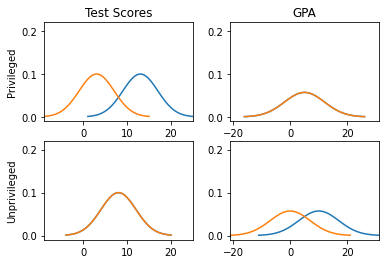

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_normal(mu, sigma, ax, label=None):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label)

f, ax = plt.subplots(2, 2)
shift_p = 0
shift_u = 0
if kwargs['shift_priv'] == True:
    shift_u = kwargs['shift_random']
if kwargs['shift_priv'] == False:
    shift_p = kwargs['shift_random']
print(shift_p, shift_u)
avg_p = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2 + shift_p
avg_u = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2 + shift_u
sigma_p = dist['sigma_ps']['p']
sigma_u = dist['sigma_ps']['u']
p_range = (min(dist['mu_ps']['p'], dist['mu_ns']['p']) - 3 * sigma_p, 
           max(dist['mu_ps']['p'], dist['mu_ns']['p']) + 3 * sigma_p
          )
u_range = (min(dist['mu_ps']['u'], dist['mu_ns']['u']) - 3 * sigma_u, 
           max(dist['mu_ps']['u'], dist['mu_ns']['u']) + 3 * sigma_u
          )
print(p_range, u_range)

combs = [
    [
        [(dist['mu_ps']['p'], dist['mu_ns']['p']), (sigma_p, sigma_p), p_range], 
        [(avg_u, avg_u), (sigma_u, sigma_u), u_range]
    ],
    [
        [(avg_p, avg_p), (sigma_p, sigma_p), p_range], 
        [(dist['mu_ps']['u'], dist['mu_ns']['u']), (sigma_u, sigma_u), u_range]
    ]
]

for i, row in enumerate(ax):
    for j, a in enumerate(row):
        mus = combs[i][j][0]
        sigmas = combs[i][j][1]
        print(mus)
        print(sigmas)
        plot_normal(mus[0], sigmas[0], a)
        plot_normal(mus[1], sigmas[1], a)
        left, right = combs[i][j][2]
        # left = min(mus[0] - 3 * sigmas[0], mus[1] - 3 * sigmas[1])
        # right = max(mus[1] + 3 * sigmas[1], mus[1] + 3 * sigmas[1])
        a.set_xlim(left,right)
        a.set_ylim(-0.01, 0.22)
        # a.vlines(np.mean(mus), 0, 0.2, color='red')
        
ax[0][0].set_title('Test Scores')
ax[0][1].set_title('GPA')

ax[0][0].set_ylabel('Privileged')
ax[1][0].set_ylabel('Unprivileged')

plt.subplots_adjust(wspace=0.25)

In [9]:
def conditional_probs(clf, x):
    temp = (clf.theta_ - x.values)
    temp = temp / clf.sigma_
    temp = (temp ** 2)/2
    temp = np.exp(- temp)
    temp = temp / np.sqrt(2 * 3.1416 * (clf.sigma_))
    # temp = np.prod(temp, axis=1)
    # temp = umod.class_prior_ * temp
    # temp = temp/ np.sum(temp)
    return temp

i = 4000
test_fd_x, _ = test_fd.get_xy(keep_protected=False)
print(test_fd_x.iloc[i:i+1])
print(test_fd.protected_attributes[i])
print(test_fd.labels[i])
print(conditional_probs(pmod, test_fd_x.iloc[i:i+1]))
print(conditional_probs(umod, test_fd_x.iloc[i:i+1]))
print(conditional_probs(mod, test_fd_x.iloc[i:i+1]))

         r_p_0     r_p_1     r_p_2     r_u_0      r_u_1     r_u_2       i_0  \
4000  6.218787  4.816019  0.309754  7.656293  10.076708 -4.049013 -9.445508   

           i_1       i_2       i_3  
4000  4.523429  9.007739 -4.881195  
[1.]
[0.]
[[0.09598604 0.09824308 0.0969556  0.0571035  0.05607516 0.05620458
  0.04430835 0.0999183  0.05067415 0.04855393]
 [0.09124642 0.08674236 0.07296935 0.05666383 0.05744376 0.05631973
  0.04399631 0.0989675  0.04746121 0.04881075]]
[[0.10126539 0.09728909 0.08937961 0.0555199  0.05599505 0.05723514
  0.04288092 0.10018284 0.0568845  0.04847857]
 [0.10003099 0.09643535 0.08851492 0.05727243 0.05731152 0.05432306
  0.04317241 0.09871018 0.04940834 0.04889828]]
[[0.08510239 0.08435993 0.08180126 0.05275527 0.05326797 0.05329457
  0.04357834 0.10001025 0.0538105  0.04850341]
 [0.08325351 0.08090736 0.07620865 0.05386196 0.05407565 0.05244653
  0.04357887 0.09883852 0.04843792 0.04885433]]


In [10]:
dist

{'mu_ps': {'p': 13, 'u': 10},
 'sigma_ps': {'p': 4, 'u': 7},
 'mu_ns': {'p': 3, 'u': 0},
 'sigma_ns': {'p': 4, 'u': 7}}

In [11]:
mod.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'n_features_in_': 10,
 'epsilon_': 8.034713869290456e-08,
 'classes_': array([0., 1.]),
 'theta_': array([[ 5.4531326 ,  5.47950205,  5.47662223,  2.43323865,  2.57419493,
          2.69647595,  6.93614061,  6.04047703,  6.99003002,  7.98704733],
        [10.46830551, 10.53270931, 10.49656504,  7.55171525,  7.58606651,
          7.46886784,  7.09898703,  5.98206104,  7.00667739,  8.07375406]]),
 'sigma_': array([[21.94861416, 22.34414599, 22.57042796, 56.70254672, 55.0583034 ,
         55.20377592, 80.39839033, 15.76553735,  1.00916015, 65.05521074],
        [22.13102324, 22.83638819, 22.20120352, 54.8596664 , 54.31282811,
         55.41449454, 80.32342518, 16.15950687,  0.97106557, 64.00613082]]),
 'class_count_': array([ 5000., 15000.]),
 'class_prior_': array([0.25, 0.75])}

In [12]:
def get_expected_x(dist, priv, ispos):
    x1, x2 = get_mus(dist, priv, ispos)
    if priv:
        x2 = x2 + 0 * dist['sigma_ps']['u']  
    else:
        x1 = x1 + 0 * dist['sigma_ps']['p']
        
    print(x1, x2)
    return x1, x2

def get_mus(dist, priv, ispos):
    if priv:
        mu2 = (dist['mu_ps']['u'] + dist['mu_ns']['u'])/2
        if ispos:
            mu1 = dist['mu_ps']['p']
        else:
            mu1 = dist['mu_ns']['p']
    else:
        mu1 = (dist['mu_ps']['p'] + dist['mu_ns']['p'])/2
        if ispos:
            mu2 = dist['mu_ps']['u']
        else:
            mu2 = dist['mu_ns']['u']
        
    # print(mu1, mu2)
    
    return mu1, mu2

In [13]:
from scipy.stats import norm
def get_cdf(mu, sigma, x):
    rv = norm(loc=mu, scale=sigma)
    return rv.cdf(x)

In [14]:
ex1, ex2 = get_expected_x(dist, priv=True, ispos=True)

13 5.0


In [15]:
def get_bounds(alpha, ex1, ex2):
    c = math.log(alpha/(1-alpha))
    x1_bound = 8 - 10.2/5*(c + 5/31.5*(ex2 - 5))
    x2_bound = 5 - 31.5/5*(c + 5/10.2*(ex1 - 8))
    return x1_bound, x2_bound

In [16]:
x1, x2 = get_bounds(0.25, ex1, ex2)
x1, x2

(10.241169068882943, -3.5199190519791443)

In [17]:
'{:.8f}'.format((1 - get_cdf(ex1, 2, x1))*(1 - get_cdf(ex2, 5, x2)))

'0.87563157'

In [18]:
(1 - get_cdf(ex1, 2, x1))

0.9161166532097544

In [19]:
(1 - get_cdf(ex2, 5, x2))

0.9558079440723021

In [20]:
rv = norm(loc=8, scale=2)
exp = 0
for i in np.arange(-20, 30, 0.01):
    prob = rv.pdf(i)
    fx = 0.01 * erf((36.2565 - 3.0488 * i)/(5 * math.sqrt(2)))
    exp += fx*prob
    
print(exp)
    

0.8676256796541201


In [21]:
1/2 - 0.5*exp

0.06618716017293996

## Theoretical Bounds

In [22]:
def get_a(sigma_1_theta, sigma_2_theta, sigma_2):
    return - (sigma_2_theta / sigma_1_theta) ** 2 / (math.sqrt(2) * sigma_2)

def get_b(sigma_1_theta, sigma_2_theta, sigma_1, sigma_2, mu_1_avg, mu_2_avg, mu, alpha, delta):
    temp = (mu_2_avg - mu)
    temp += (sigma_2_theta / sigma_1_theta) ** 2 * mu_1_avg
    temp -= (sigma_2_theta ** 2 / delta) * math.log(alpha/(1-alpha))
    temp /= (math.sqrt(2) * sigma_2)
    return temp    

def get_selection_rate(s, is_pos, dist, dist_theta, delta, alpha):
    if is_pos:
        if s == 'p':
            mu_1 = dist['mu_ps']['p']
            mu_2 = dist_theta['mu'][2]
        else:
            mu_1 = dist_theta['mu'][1]
            mu_2 = dist['mu_ps']['u']
    else:
        if s == 'p':
            mu_1 = dist['mu_ns']['p']
            mu_2 = dist_theta['mu'][2]
        else:
            mu_1 = dist_theta['mu'][1]
            mu_2 = dist['mu_ns']['u']

    sigma_1_theta = dist_theta['sigma'][1]
    sigma_2_theta = dist_theta['sigma'][2]
    sigma_1 = dist['sigma_ps']['p']
    sigma_2 = dist['sigma_ps']['u']
    mu_1_avg = dist_theta['mu'][1]
    mu_2_avg = dist_theta['mu'][2]
    
    a = get_a(sigma_1_theta, sigma_2_theta, sigma_2)
    b = get_b(sigma_1_theta, sigma_2_theta, sigma_1, sigma_2, 
              mu_1_avg, mu_2_avg, mu_2, alpha, delta)
    # print((a * mu_1 + b)/np.sqrt(1+a**2 * sigma_1**2))
    # print(np.sqrt(1+a**2 * sigma_1**2))
    
    return 0.5 * (1 - erf((a * mu_1 + b)/np.sqrt(1+a**2 * sigma_1**2)))

In [23]:
dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 40, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 40, 'u': 110}
}

delta = dist['mu_ps']['p'] - dist['mu_ns']['p']

mu_1_avg = (dist['mu_ps']['p'] + dist['mu_ns']['p']) / 2
mu_2_avg = (dist['mu_ps']['u'] + dist['mu_ns']['u']) / 2
sigma_1_theta = np.sqrt(dist['sigma_ps']['p']**2 
                        + (dist['mu_ps']['p'] - dist['mu_ns']['p'])**2 / 16)
sigma_2_theta = np.sqrt(dist['sigma_ps']['u']**2 
                        + (dist['mu_ps']['u'] - dist['mu_ns']['u'])**2 / 16)
dist_theta = {'mu': {1: mu_1_avg, 2: mu_2_avg},
             'sigma': {1: sigma_1_theta, 2: sigma_2_theta}
             }
print(mu_1_avg, mu_2_avg, sigma_1_theta, sigma_2_theta, delta)

53.0 50.0 47.16990566028302 112.80514172678478 100


In [24]:
get_selection_rate('p', True, dist, dist_theta, delta, 0.25)

0.7725142260923433

In [25]:
get_selection_rate('p', False, dist, dist_theta, delta, .25)

0.014760783551900025

In [26]:
get_selection_rate('u', True, dist, dist_theta, delta, 0.25)

0.32309938259038007

In [27]:
get_selection_rate('u', False, dist, dist_theta, delta, 0.25)

0.16596117525660198

In [28]:
sigma_theta_1 = dist_theta['sigma'][1]
sigma_theta_2 = dist_theta['sigma'][2]
sigma_1 = dist['sigma_ps']['p']
sigma_2 = dist['sigma_ps']['u']
a = (sigma_theta_2/sigma_theta_1) ** 2 / (math.sqrt(2) * sigma_2)
c1 = a * delta / (2  * np.sqrt(1 + (a * sigma_1)**2))
print(c1)
c3 = delta / (2 * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a**2 * sigma_1**2)))
print(c3)
alpha = 0.25
c2 = (sigma_theta_2)**2 / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2))
print(c2)
c_alpha = np.log(alpha/(1-alpha))
print(c_alpha)
4 * c3 * (sigma_theta_2)**2 / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2)) < 1

1.033649846800481
0.1807364172205163
0.4599741818262142
-1.0986122886681098


True

In [29]:
temp_dist = deepcopy(dist)

print('i', ['c1', 'c2', 'c3', 'c1 + c2', 'c3 + c2', 'c1 - c2', 'c3 - c2'], sep='\t')
def func(sigma_1, sigma_2, delta):
    sigma_theta_1 = np.sqrt(sigma_1**2 + delta**2/16)
    sigma_theta_2 = np.sqrt(sigma_2**2 + delta**2/16)
    
    lhs = (delta**2 / 16) * (sigma_theta_2**2 + sigma_theta_1**2)
    rhs = (sigma_theta_2**2 * sigma_1**2 + sigma_theta_1**2 * sigma_2**2)
    print(sigma_1, sigma_2, sigma_theta_1, sigma_theta_2, int(lhs), int(rhs))
    return lhs> rhs

temp_dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 30, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 30, 'u': 110}
}

for i in range(30, 200, 10):
    temp_dist['sigma_ps']['u'] = temp_dist['sigma_ns']['u'] = i
    sigma_1 = temp_dist['sigma_ps']['p']
    sigma_2 = temp_dist['sigma_ps']['u']
    sigma_theta_1 = np.sqrt(sigma_1**2 + delta**2/16)
    sigma_theta_2 = np.sqrt(sigma_2**2 + delta**2/16)
    a = (sigma_theta_2/sigma_theta_1) ** 2 / (math.sqrt(2) * sigma_2)
    c1 = a * delta / (2  * np.sqrt(1 + 2*(a * sigma_1)**2))
    # print(c1)
    c3 = delta / (2 * np.sqrt(2) * sigma_2 * np.sqrt(1 + 2*(a**2 * sigma_1**2)))
    # print(c3)
    alpha = 0.25
    c2 = (sigma_theta_2)**2 * np.log(alpha/(1-alpha)*2) / (delta * np.sqrt(2) * sigma_2 * np.sqrt(1 + (a * sigma_1)**2))
    # print(c2)
    cond = func(sigma_1, sigma_2, delta)
    print(i, ['{:.4f}'.format(f) for f in [c1, c2, c3, c1+c2, c3+c2, c1-c2, c3-c2]], cond, sep='\t')

i	['c1', 'c2', 'c3', 'c1 + c2', 'c3 + c2', 'c1 - c2', 'c3 - c2']
30 30 39.05124837953327 39.05124837953327 1906249 2744999
30	['0.8333', '-0.1190', '0.8333', '0.7143', '0.7143', '0.9523', '0.9523']	False
30 40 39.05124837953327 47.16990566028302 2343750 4442500
40	['0.8700', '-0.1261', '0.5963', '0.7438', '0.4701', '0.9961', '0.7224']	False
30 50 39.05124837953327 55.90169943749474 2906250 6625000
50	['0.9143', '-0.1352', '0.4462', '0.7791', '0.3109', '1.0495', '0.5814']	False
30 60 39.05124837953327 65.0 3593750 9292500
60	['0.9555', '-0.1442', '0.3449', '0.8113', '0.2007', '1.0998', '0.4891']	False
30 70 39.05124837953327 74.33034373659252 4406250 12445000
70	['0.9908', '-0.1524', '0.2735', '0.8384', '0.1211', '1.1432', '0.4259']	False
30 80 39.05124837953327 83.81527307120105 5343750 16082499
80	['1.0199', '-0.1595', '0.2214', '0.8605', '0.0619', '1.1794', '0.3809']	False
30 90 39.05124837953327 93.40770846134703 6406250 20205000
90	['1.0437', '-0.1656', '0.1824', '0.8782', '0.0169'

(0.053023995525617935, 0.05342948072969357, 0.1)
(0.0986669245589741, 0.09941693359613071, 0.15000000000000002)
(0.1496926239591474, 0.15066157803401142, 0.20000000000000004)
(0.20419914418701096, 0.20524572709004668, 0.25000000000000006)
(0.26106788837976586, 0.2620638391071948, 0.30000000000000004)
(0.31956155295011995, 0.3204013775393985, 0.3500000000000001)
(0.3791482901901498, 0.3797523542056599, 0.40000000000000013)
(0.4394119858430373, 0.4397272480846831, 0.45000000000000007)
(0.5000000000000001, 0.5000000000000002, 0.5000000000000001)
(0.560588014156963, 0.5602727519153172, 0.5500000000000002)
(0.6208517098098506, 0.6202476457943406, 0.6000000000000002)
(0.6804384470498803, 0.6795986224606019, 0.6500000000000001)
(0.7389321116202344, 0.7379361608928057, 0.7000000000000002)
(0.7958008558129894, 0.7947542729099537, 0.7500000000000002)
(0.8503073760408529, 0.8493384219659887, 0.8000000000000002)
(0.9013330754410261, 0.9005830664038696, 0.8500000000000002)
(0.9469760044743822, 0.94

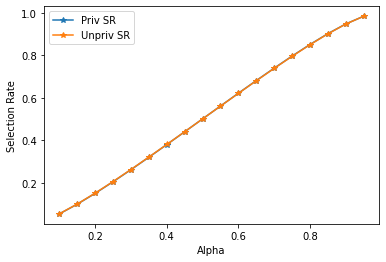

In [30]:
alphas = list(np.arange(.1, 1, 0.05))
tps = [get_selection_rate('p', True, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, tps, label='Priv TP')
fps = [get_selection_rate('p', False, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, fps, label='Priv FP')

# print(*list(zip(tps, fps, alphas)), sep='\n')

sr_p = [alphas[i] * tps[i] + (1 - alphas[i]) * fps[i] for i in range(len(alphas))]
plt.plot(alphas, sr_p, '*-', label='Priv SR')

tps = [get_selection_rate('u', True, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, tps, label='Unpriv TP')
fps = [get_selection_rate('u', False, dist, dist_theta, delta, alpha) for alpha in alphas]
# plt.plot(alphas, fps, label='Unpriv FP')

# print()

# print(*list(zip(tps, fps, alphas)), sep='\n')

sr_u = [alphas[i] * tps[i] + (1 - alphas[i]) * fps[i] for i in range(len(alphas))]
plt.plot(alphas, sr_u, '*-', label='Unpriv SR')
# print()
print(*list(zip(sr_p, sr_u, alphas)), sep='\n')

plt.xlabel('Alpha')
plt.ylabel('Selection Rate')
plt.legend()
plt.savefig('theo_selection_rate_delta_{:d}_s1_{:d}_s2_{:d}.pdf'.
            format(delta, dist['sigma_ps']['p'], dist['sigma_ps']['u']), format='pdf')

In [31]:
def ddx_erf(x):
    return np.exp(-x**2)*2/np.sqrt(math.pi)

ddx_erf(2)

0.020666985354092053

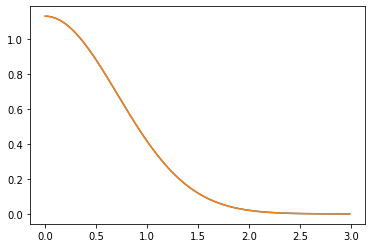

In [32]:
xs = np.arange(0, 3, 0.01)
plt.plot(xs, [ddx_erf(x) for x in xs])
xs = np.arange(0, 3, 0.01)
plt.plot(xs, [ddx_erf(x) for x in xs])

In [33]:
sigma_1 = 30
sigma_2 = 90
delta = 100
2 *(sigma_2**2 + delta/16) > (sigma_1**2 + delta/16) **2 * sigma_2**2 + (sigma_2**2 + delta/16) **2 * sigma_1**2


False

In [34]:
2 *(sigma_2**2 + delta/16)

16212.5

In [35]:
(sigma_1**2 + delta/16) **2 * sigma_2**2 + (sigma_2**2 + delta/16) **2 * sigma_1**2

65792601562.5

### Just random testing equations.

In [36]:
dist = {
    'mu_ps': {'p': 103, 'u': 100},
    'sigma_ps': {'p': 40, 'u': 110},
    'mu_ns': {'p': 3,'u': 0},
    'sigma_ns': {'p': 40, 'u': 110}
}

In [37]:
mu_1_p_plus = 13
mu_1_p_minus = 3
mu_1_u_plus = mu_1_u_minus = 8
mu_2_p_plus = mu_2_p_minus = 5
mu_2_u_plus = 10
mu_2_u_minus = 0
sigma_1 = 2
sigma_2 = 5
sigma_1_theta_sqr = 10.25
sigma_2_theta_sqr = 31.25

mu_1_avg = 8
mu_2_avg = 5

alpha = 0.25
c_alpha = np.log(alpha/(1-alpha))
delta = 10

Equation inside erf for $P(\hat{y}^+| y^+, p)$

In [38]:
b = mu_2_avg - mu_2_p_plus 
b += (mu_1_avg) * (sigma_2_theta_sqr)/sigma_1_theta_sqr
b -= sigma_2_theta_sqr/delta * c_alpha

b = b / (np.sqrt(2) * sigma_2)

a = - (sigma_2_theta_sqr/sigma_1_theta_sqr)*1/(np.sqrt(2) * sigma_2)
(a*mu_1_p_plus + b)/(np.sqrt(1 + 2 * a**2 * sigma_1**2))

-1.0590972600198978

In [39]:
numerator = sigma_1_theta_sqr * 0 * (-delta / 2) 
numerator += sigma_2_theta_sqr * 1 * (-delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

-1.0590972600198976

Equation inside erf for $P(\hat{y}^+| y^+, u)$

In [40]:
numerator = sigma_1_theta_sqr * 1 * (-delta / 2) 
numerator += sigma_2_theta_sqr * 0 * (-delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

-0.14050199082021922

Equation inside erf for $P(\hat{y}^+| y^-, p)$

In [41]:
numerator = sigma_1_theta_sqr * 0 * (delta / 2) 
numerator += sigma_2_theta_sqr * 1 * (delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

1.674817231645812

Equation inside erf for $P(\hat{y}^+| y^-, p)$

In [42]:
numerator = sigma_1_theta_sqr * 1 * (delta / 2) 
numerator += sigma_2_theta_sqr * 0 * (delta / 2) 
numerator -= sigma_1_theta_sqr * sigma_2_theta_sqr * c_alpha / delta

denominator = sigma_1_theta_sqr ** 2 * sigma_2 ** 2
denominator += sigma_2_theta_sqr ** 2 * sigma_1 ** 2
denominator = np.sqrt(2 * denominator)
numerator / denominator

0.7562219624461336

###### Experiment with r and $\Delta$

In [43]:
def h(sigma_1, delta, r, alpha):
    tp_priv = get_selection_rate(sigma_1, delta, r, alpha, True, True)
    fp_priv = get_selection_rate(sigma_1, delta, r, alpha, True, False)
    tp_unpriv = get_selection_rate(sigma_1, delta, r, alpha, False, True)
    fp_unpriv = get_selection_rate(sigma_1, delta, r, alpha, False, False)
    
    return alpha * (tp_priv - tp_unpriv) + (1-alpha) * (fp_priv - fp_unpriv)

In [44]:
sigma_1 = 2
delta = 10
r = 2.5
alpha = 0.25
print('priv_tp', get_selection_rate(sigma_1, delta, r, alpha, True, True))
print('priv_fp', get_selection_rate(sigma_1, delta, r, alpha, True, False))
print('unpriv_tp', get_selection_rate(sigma_1, delta, r, alpha, False, True))
print('unpriv_fp', get_selection_rate(sigma_1, delta, r, alpha, False, False))
h(sigma_1, delta, r, alpha)

TypeError: 'float' object is not subscriptable

In [ ]:
priv_tp 0.8559751887806584
priv_fp 0.0025242009584636182
unpriv_tp 0.4064525467662099
unpriv_fp 0.06618272136578918
0.06463677019811795

{'mu_ps': {'p': 103, 'u': 100}, 'sigma_ps': {'p': 40, 'u': 100}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 40, 'u': 100}}
alpha 0.1
mod
{'TP': 86.0, 'FP': 41.0, 'TN': 8959.0, 'FN': 914.0}
SR	 0.0127
PSR	 0.0136
PTPR	 0.132
PFPR	 0.00044444444444444447
USR	 0.0118
UTPR	 0.04
UFPR	 0.008666666666666666
alpha 0.25
mod
{'TP': 901.0, 'FP': 446.0, 'TN': 7054.0, 'FN': 1599.0}
SR	 0.1347
PSR	 0.1386
PTPR	 0.508
PFPR	 0.015466666666666667
USR	 0.1308
UTPR	 0.2128
UFPR	 0.10346666666666667
alpha 0.5
mod
{'TP': 3611.0, 'FP': 1370.0, 'TN': 3630.0, 'FN': 1389.0}
SR	 0.4981
PSR	 0.4994
PTPR	 0.8596
PFPR	 0.1392
USR	 0.4968
UTPR	 0.5848
UFPR	 0.4088
alpha 0.75
mod
{'TP': 7115.0, 'FP': 1639.0, 'TN': 861.0, 'FN': 385.0}
SR	 0.8754
PSR	 0.8618
PTPR	 0.9845333333333334
PFPR	 0.4936
USR	 0.889
UTPR	 0.9128
UFPR	 0.8176
alpha 0.9
mod
{'TP': 8964.0, 'FP': 918.0, 'TN': 82.0, 'FN': 36.0}
SR	 0.9882
PSR	 0.9862
PTPR	 0.9995555555555555
PFPR	 0.866
USR	 0.9902
UTPR	 0.9924444444444445
UFPR	 0.97

In [ ]:
sigma_1 = 40
delta = 100
r = 2.5
for alpha in [0.1, 0.25, 0.5, 0.75, 0.9]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    # print(psr, usr, psr - usr)
    # print(tp, fp)

In [ ]:
sigma_1 = 2
delta = 10
alpha = 0.25

for r in [1, 1.25, 2.5, 5, 10, 20, 40]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    # print(psr, usr, psr - usr)
    # print(tp, fp)

In [ ]:
sigma_1 = 20
delta = 100
alpha = 0.25
r = 2.5
for delta in [10, 20, 30, 40, 50]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    # print(psr, usr, psr - usr)
    # print(tp, fp)
    
print()
alpha = 0.75
for delta in [10, 20, 30, 40, 50]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    # print(psr, usr, psr - usr)
    # print(tp, fp)

In [ ]:
sigma_1 = 20
delta = 100
alpha = 0.25
r = 2.5
for sigma_1 in [40, 60, 80, 100, 120, 200, 300]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    #print(psr, usr, psr - usr)
    # print(tp, fp)
    
#print()
alpha = 0.75
for sigma_1 in [40, 60, 80, 100, 120, 200, 300]:
    priv = True
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    psr = alpha * tp + (1-alpha) * fp
    priv = False
    tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
    fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
    usr = alpha * tp + (1-alpha) * fp
    #print(psr, usr, psr - usr)
    # print(tp, fp)

In [ ]:
sigma_1 = 20
delta = 100
alpha = 0.25
r = 2.5
hs = []
for sigma_1 in [20, 40, 60, 80, 100, 120, 200, 300]:
    for delta in [10, 20, 30, 40, 50, 100]:
        for r in [1, 1.5, 2, 2.5, 5, 10, 20]:
            #print(sigma_1, delta, r, r*sigma_1)
            new_hs = []
            for alpha in [0.1, 0.25, 0.5, 0.75, 0.9]:
                priv = True
                tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
                fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
                psr = alpha * tp + (1-alpha) * fp
                priv = False
                tp = get_selection_rate(sigma_1, delta, r, alpha, priv, True)
                fp = get_selection_rate(sigma_1, delta, r, alpha, priv, False)
                usr = alpha * tp + (1-alpha) * fp
                new_hs.append(psr - usr)
            hs.append(new_hs)
            #print(new_hs)

##### Plot erf function

In [ ]:
# (1, 3, 1.25)
sigma_1 = 2
delta = 10
r = 2.5
alpha = 0.25

erfs = []
start = - 250
end = 250
for i in range(start, end + 1):
    erfs.append(erf(i/100))
    
plt.plot([i/100 for i in range(start, end + 1)], erfs, color='black')

calpha = np.log(alpha/(1-alpha))
c1, c2, c3 = get_c123(sigma_1, r * sigma_1, delta)
print(calpha, c1, c2, c3)
points = [c1, c3, c1+c2*calpha, c3+c2*calpha, c3-c2*calpha, c1-c2*calpha]
print(points)
plt.plot(points, [erf(p) for p in points], 'o', color='black')

texts = [r'$c_1$', r'$c_3$', r'$c_1+c_2*c_\alpha$', r'$c_3+c_2*c_\alpha$', r'$c_3 - c_2*c_\alpha$', r'$c_1 - c_2*c_\alpha$']

ax = plt.gca()
    
fontsize = 18.33
    
ax.annotate(texts[0], (points[0] - 0.3, erf(points[0]) + 0.1), fontsize=fontsize)
ax.annotate(texts[1], (points[1] - 0.3, erf(points[1]) + 0.1), fontsize=fontsize)
ax.annotate(texts[2], (points[2] - 1.5, erf(points[2]) + 0.1), fontsize=fontsize)
ax.annotate(texts[3], (points[3] - 1.5, erf(points[3]) + 0.1), fontsize=fontsize)
ax.annotate(texts[4], (points[4] , erf(points[4]) - 1.1), fontsize=fontsize, rotation=90)
ax.annotate(texts[5], (points[5] , erf(points[5]) - 1.1), fontsize=fontsize, rotation=90)

plt.ylim(-1.1, 1.3)
plt.xlim(-2.5, 2.5)
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.xlabel('x')
plt.ylabel('erf(x)')
plt.tight_layout()

cdiff = c1 - c3
mid_points = [(c1+c3)/2, (c1+c3)/2 + c2*calpha, (c1+c3)/2 - c2*calpha]
mid_texts = [r'$\dfrac{c_1 + c_3}{2}$', 
             r'$\dfrac{c_1 + c_3}{2} + c_2 c_{\alpha}$', 
             r'$\dfrac{c_1 + c_3}{2} - c_2 c_{\alpha}$']
plt.plot(mid_points, [erf(i) for i in mid_points], 'o', color='black')

ax = plt.gca()
for i, p in enumerate(mid_points[:-1]):
    # ax.annotate(mid_texts[i], (p, erf(p) + 0.2))
    pass

plt.plot([c1+c2*calpha, c3+c2*calpha], [erf(i) for i in [c1+c2*calpha, c3+c2*calpha]], color='black')
plt.plot([c1+c2*calpha, c1+c2*calpha], [erf(c1+c2*calpha), erf(c3+c2*calpha)], color='black')
plt.plot([c3+c2*calpha, c1+c2*calpha], [erf(c3+c2*calpha), erf(c3+c2*calpha)], color='black')

plt.plot([c1-c2*calpha, c3-c2*calpha], [erf(c1-c2*calpha), erf(c3-c2*calpha)], color='black')
plt.plot([c1-c2*calpha, c1-c2*calpha], [erf(c1-c2*calpha), erf(c3-c2*calpha)], color='black')
plt.plot([c3-c2*calpha, c1-c2*calpha], [erf(c3-c2*calpha), erf(c3-c2*calpha)], color='black')

plt.savefig('erf_plot.pdf', format='pdf')

In [ ]:
sigma_1 = 1000
sigma_2 = 2500
 
c2s = {}
for delta in range(5, 10000, 5):
    _, c2, _ = get_c123(sigma_1, sigma_2, delta/10)
    c2s[delta/10] = 2*c2
    
print(min(c2s.values()))
plt.plot(c2s.keys(), c2s.values())
plt.hlines(1, -5, 150)